# Search all Parameters and HyperParameters

### Load Entire Dataset
51 seconds

In [1]:
import time

# REVIEW_FILE_CSV = 'reviews.csv'
SHUFFLED_REVIEW_FILE_CSV = 'shuffled.100000.reviews.csv'  # 'shuffled.reviews.csv'
import pandas as pd

# GLOBAL VAR df_all <-- all review data
start = time.time()

df_all = pd.read_csv(SHUFFLED_REVIEW_FILE_CSV)

csv_load_time = time.time() - start

print(str(round(csv_load_time, 2)) + ' seconds loading CSV into memory\n')
del pd, SHUFFLED_REVIEW_FILE_CSV, start, csv_load_time, time

%whos

0.24 seconds loading CSV into memory

Variable   Type         Data/Info
---------------------------------
df_all     DataFrame           Unnamed: 0        <...>[30812 rows x 10 columns]


### Data Prep Functions

In [2]:
def get_data(size, metric):
    return df_all[[metric, 'text']].head(size)


def data_prep(df, metric):
    from keras.preprocessing.text import Tokenizer
    from keras.preprocessing.sequence import pad_sequences
    from sklearn.model_selection import train_test_split

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df.text.values)
    VOCAB_SIZE = len(tokenizer.word_index) + 1

    X = tokenizer.texts_to_sequences(df.text.values)
    X = pad_sequences(X)
    # Normalize Y to be between 0 and 1
    Y = df[metric] / max(df[metric])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

    return X, Y, VOCAB_SIZE, X_train, X_test, Y_train, Y_test

### Parameterized Neural Net Factory

In [3]:
def model_factory(X_train, VOCAB_SIZE, EMBED_OUTPUT_DIM, LSTM_LAYER_COUNT, LSTM_OUT, LSTM_DROPOUT, RECURRENT_DROPOUT, USE_SPATIAL_DROPOUT, SPATIAL_DROPOUT):
    from keras.models import Sequential
    from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

    model = Sequential()

    # TODO https://realpython.com/python-keras-text-classification/

    # https://keras.io/layers/embeddings/
    # keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)
    model.add(Embedding(VOCAB_SIZE,
                        EMBED_OUTPUT_DIM,
                        mask_zero=True,
                        input_length=X_train.shape[1]))

    if USE_SPATIAL_DROPOUT:
        model.add(SpatialDropout1D(SPATIAL_DROPOUT))

    if LSTM_LAYER_COUNT > 1:
        for i in range(LSTM_LAYER_COUNT):
            model.add(LSTM(LSTM_OUT, return_sequences=True, dropout=LSTM_DROPOUT, recurrent_dropout=RECURRENT_DROPOUT))

    model.add(LSTM(LSTM_OUT, dropout=LSTM_DROPOUT, recurrent_dropout=RECURRENT_DROPOUT))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])
    return model

### induce and evaluate

In [4]:
def evaluate_model(model, history, X_test, Y_test, BATCH_SIZE):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(history.history['acc'], '.-')
    plt.plot(history.history['val_acc'], '.-')
    plt.plot(history.history['loss'], '.-')
    plt.plot(history.history['val_loss'], '.-')

    plt.title('training')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='best')
    plt.show()

    loss, mae, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=BATCH_SIZE)
    print('loss(mse):' + str(loss))  # mse
    print('mae:' + str(mae))
    print('acc:' + str(acc))

    y_pred = model.predict(X_test)
    # y_pred[0:5]
    # Y_test[0:5]

    fig, ax = plt.subplots()
    ax.scatter(Y_test, y_pred)
    ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

    return loss, mae, acc

## run experiment

In [5]:
def run_experiment(DATA_SIZE, METRIC, EMBED_OUTPUT_DIM, LSTM_LAYER_COUNT, LSTM_OUT, LSTM_DROPOUT, RECURRENT_DROPOUT, USE_SPATIAL_DROPOUT, SPATIAL_DROPOUT,
                   EPOCHS, BATCH_SIZE):
    import time

    df = get_data(DATA_SIZE, METRIC)
    X, Y, VOCAB_SIZE, X_train, X_test, Y_train, Y_test = data_prep(df, METRIC)

    model = model_factory(X_train, VOCAB_SIZE, EMBED_OUTPUT_DIM, LSTM_LAYER_COUNT, LSTM_OUT, LSTM_DROPOUT, RECURRENT_DROPOUT, USE_SPATIAL_DROPOUT,
                          SPATIAL_DROPOUT)
    print(model.summary())

    start_time = time.time()
    history = model.fit(X_train, Y_train, validation_split=0.333, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
    fit_time = time.time() - start_time

    loss, mae, acc = evaluate_model(model, history, X_test, Y_test, BATCH_SIZE)

    return loss, mae, acc, fit_time, model

### basic/slow grid search

In [6]:
def grid_search():
    import uuid
    import pandas as pd

    DATA_SIZES = [10, 100]
    METRICS = ['stars', 'funny', 'useful', 'cool']

    # NN
    EMBED_OUTPUT_DIMS = [8, 16]  # 128
    USE_SPATIAL_DROPOUTS = [False, True]
    SPATIAL_DROPOUTS = [0.0, 0.1]
    LSTM_LAYER_COUNTS = [1, 2]
    LSTM_OUTS = [8, 16]  # 196
    LSTM_DROPOUTS = [0.0, 0.1]
    RECURRENT_DROPOUTS = [0.0, 0.1]

    # INDUCTION
    EPOCHS = [1, 2]
    BATCH_SIZES = [64, 128]
    LEARNING_RATES = [0.1, 0.001]

    ####################
    ### BIG ASS LOOP ###
    ####################
    results_dict = {}

    for EMBED_OUTPUT_DIM in EMBED_OUTPUT_DIMS:
        for USE_SPATIAL_DROPOUT in USE_SPATIAL_DROPOUTS:
            for SPATIAL_DROPOUT in SPATIAL_DROPOUTS:
                for LSTM_LAYER_COUNT in LSTM_LAYER_COUNTS:
                    for LSTM_OUT in LSTM_OUTS:
                        for LSTM_DROPOUT in LSTM_DROPOUTS:
                            for RECURRENT_DROPOUT in RECURRENT_DROPOUTS:
                                for BATCH_SIZE in BATCH_SIZES:
                                    for LEARNING_RATE in LEARNING_RATES:
                                        for EPOCH in EPOCHS:
                                            for DATA_SIZE in DATA_SIZES:
                                                for METRIC in METRICS:
                                                    results_dict['EMBED_OUTPUT_DIM'] = EMBED_OUTPUT_DIM
                                                    results_dict['USE_SPATIAL_DROPOUT'] = USE_SPATIAL_DROPOUT
                                                    results_dict['SPATIAL_DROPOUT'] = SPATIAL_DROPOUT
                                                    results_dict['LSTM_LAYER_COUNT'] = LSTM_LAYER_COUNT
                                                    results_dict['LSTM_OUT'] = LSTM_OUT
                                                    results_dict['LSTM_DROPOUT'] = LSTM_DROPOUT
                                                    results_dict['RECURRENT_DROPOUT'] = RECURRENT_DROPOUT
                                                    results_dict['BATCH_SIZE'] = BATCH_SIZE
                                                    results_dict['LEARNING_RATE'] = LEARNING_RATE
                                                    results_dict['EPOCH'] = EPOCH
                                                    results_dict['DATA_SIZE'] = DATA_SIZE
                                                    results_dict['METRIC'] = METRIC

                                                    loss, mae, acc, fit_time, model = run_experiment(DATA_SIZE,
                                                                                                     METRIC,
                                                                                                     EMBED_OUTPUT_DIM,
                                                                                                     LSTM_LAYER_COUNT,
                                                                                                     LSTM_OUT,
                                                                                                     LSTM_DROPOUT,
                                                                                                     RECURRENT_DROPOUT,
                                                                                                     USE_SPATIAL_DROPOUT,
                                                                                                     SPATIAL_DROPOUT,
                                                                                                     EPOCH,
                                                                                                     BATCH_SIZE)

                                                    results_dict['loss'] = loss
                                                    results_dict['mae'] = mae
                                                    results_dict['acc'] = acc
                                                    results_dict['fit_time'] = fit_time

                                                    model_uuid = uuid.uuid4().hex
                                                    results_dict['model_uuid'] = model_uuid

                                                    model.save(model_uuid + '.h5')

                                                    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
                                                    results_df.to_csv(model_uuid + '.csv')                                                    

Using TensorFlow backend.
/home/will/anaconda3/envs/Yelp_NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/will/anaconda3/envs/Yelp_NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/will/anaconda3/envs/Yelp_NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/will/anaconda3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 231, 8)            3512      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None


W0804 18:20:39.086504 140202658228032 deprecation_wrapper.py:119] From /home/will/anaconda3/envs/Yelp_NLP/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0804 18:20:39.166329 140202658228032 deprecation_wrapper.py:119] From /home/will/anaconda3/envs/Yelp_NLP/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 2s - loss: 0.6760 - mean_absolute_error: 0.7509 - acc: 0.0000e+00 - val_loss: 0.8153 - val_mean_absolute_error: 0.8979 - val_acc: 0.0000e+00


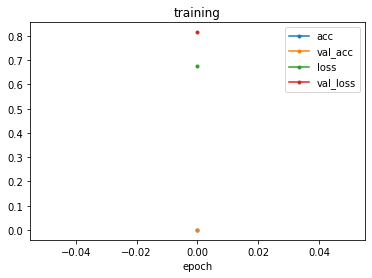

loss(mse):0.7224459052085876
mae:0.845496654510498
acc:0.0


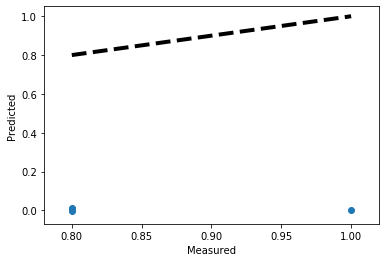

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 231, 8)            3512      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 1s - loss: 0.2492 - mean_absolute_error: 0.2543 - acc: 0.7500 - val_loss: 2.6880e-05 - val_mean_absolute_error: 0.0042 - val_acc: 1.0000


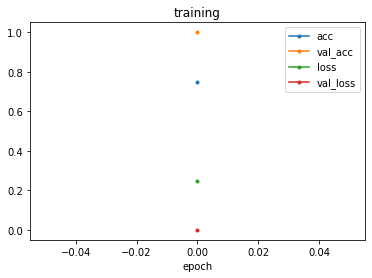

loss(mse):0.24576720595359802
mae:0.2536722719669342
acc:0.75


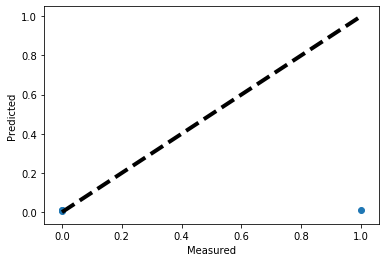

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 231, 8)            3512      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 1s - loss: 0.3146 - mean_absolute_error: 0.3783 - acc: 0.5000 - val_loss: 0.0306 - val_mean_absolute_error: 0.1288 - val_acc: 0.5000


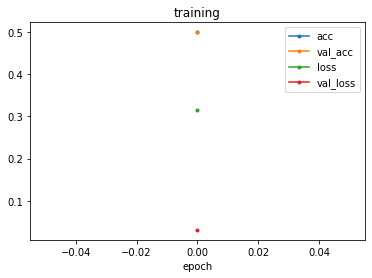

loss(mse):0.05936121195554733
mae:0.12955720722675323
acc:0.75


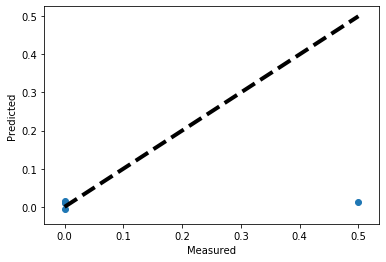

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 231, 8)            3512      
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 2s - loss: 0.2752 - mean_absolute_error: 0.3350 - acc: 0.5000 - val_loss: 8.6555e-05 - val_mean_absolute_error: 0.0082 - val_acc: 1.0000


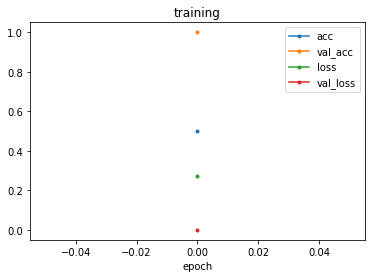

loss(mse):6.838900299044326e-05
mae:0.006550375372171402
acc:1.0


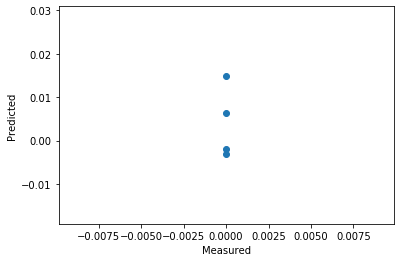

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 790, 8)            19880     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 3s - loss: 0.6038 - mean_absolute_error: 0.7039 - acc: 0.0000e+00 - val_loss: 0.6083 - val_mean_absolute_error: 0.7242 - val_acc: 0.0000e+00


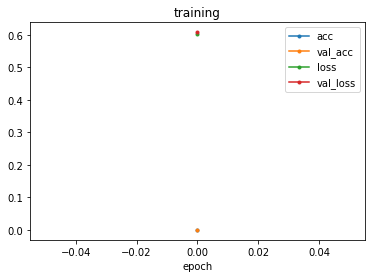

loss(mse):0.6276347637176514
mae:0.7319121360778809
acc:0.0


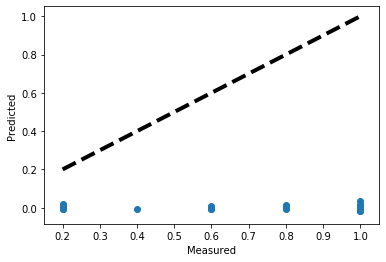

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 790, 8)            19880     
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 3s - loss: 0.0013 - mean_absolute_error: 0.0178 - acc: 0.8636 - val_loss: 0.0607 - val_mean_absolute_error: 0.1005 - val_acc: 0.6957


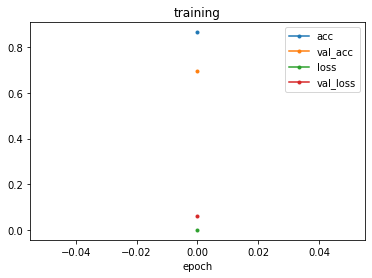

loss(mse):0.0013673234498128295
mae:0.01684175431728363
acc:0.9090909361839294


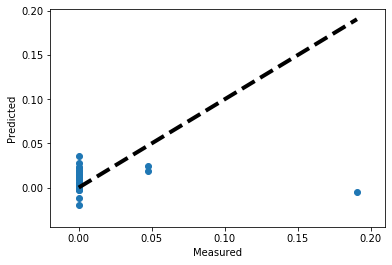

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 790, 8)            19880     
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 3s - loss: 0.0134 - mean_absolute_error: 0.0536 - acc: 0.5000 - val_loss: 0.0594 - val_mean_absolute_error: 0.1124 - val_acc: 0.4348


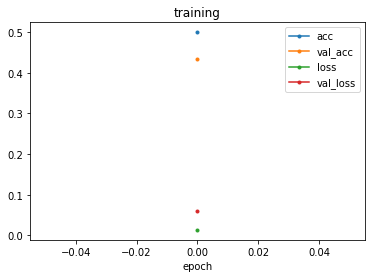

loss(mse):0.006093065720051527
mae:0.04190010204911232
acc:0.5151515007019043


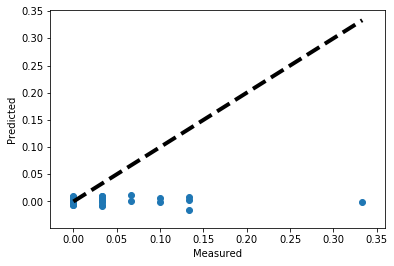

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 790, 8)            19880     
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 3s - loss: 2.0848e-04 - mean_absolute_error: 0.0093 - acc: 0.9091 - val_loss: 0.0519 - val_mean_absolute_error: 0.0846 - val_acc: 0.6087


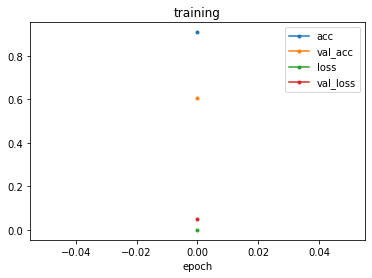

loss(mse):0.0011382020311430097
mae:0.02226233296096325
acc:0.6666666865348816


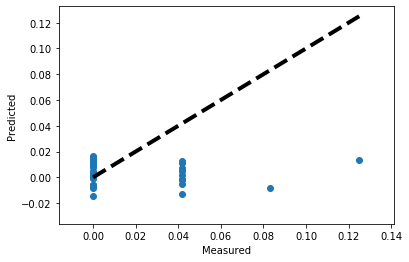

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 231, 8)            3512      
_________________________________________________________________
lstm_9 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 2s - loss: 0.6695 - mean_absolute_error: 0.7521 - acc: 0.0000e+00 - val_loss: 0.8042 - val_mean_absolute_error: 0.8921 - val_acc: 0.0000e+00
Epoch 2/2
 - 0s - loss: 0.6615 - mean_absolute_error: 0.7468 - acc: 0.0000e+00 - val_loss: 0.7966 - val_mean_absolute_error: 0.8878 - val_acc: 0.0000e+00


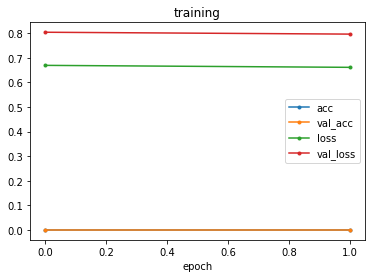

loss(mse):0.7204425930976868
mae:0.8441694378852844
acc:0.0


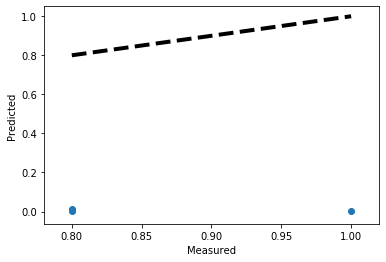

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 2s - loss: 0.2512 - mean_absolute_error: 0.2534 - acc: 0.7500 - val_loss: 1.4015e-05 - val_mean_absolute_error: 0.0035 - val_acc: 1.0000
Epoch 2/2
 - 0s - loss: 0.2482 - mean_absolute_error: 0.2524 - acc: 0.7500 - val_loss: 5.5057e-05 - val_mean_absolute_error: 0.0065 - val_acc: 1.0000


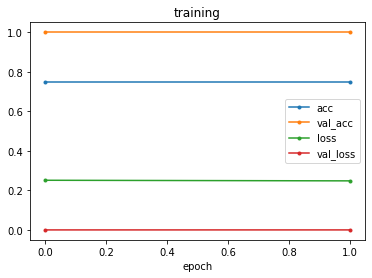

loss(mse):0.24807597696781158
mae:0.25628602504730225
acc:0.75


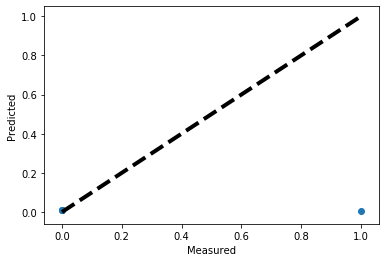

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 3s - loss: 0.3160 - mean_absolute_error: 0.3874 - acc: 0.5000 - val_loss: 0.0255 - val_mean_absolute_error: 0.1161 - val_acc: 0.5000
Epoch 2/2
 - 0s - loss: 0.3113 - mean_absolute_error: 0.3815 - acc: 0.5000 - val_loss: 0.0247 - val_mean_absolute_error: 0.1161 - val_acc: 0.5000


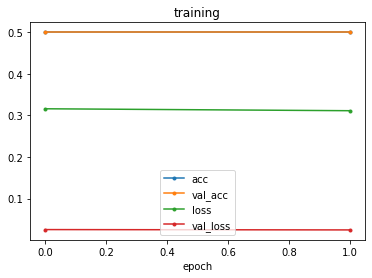

loss(mse):0.0596645250916481
mae:0.12992456555366516
acc:0.75


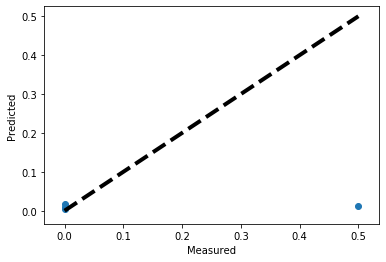

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 3s - loss: 0.2797 - mean_absolute_error: 0.3410 - acc: 0.5000 - val_loss: 3.1548e-04 - val_mean_absolute_error: 0.0176 - val_acc: 1.0000
Epoch 2/2
 - 0s - loss: 0.2749 - mean_absolute_error: 0.3368 - acc: 0.5000 - val_loss: 3.6930e-04 - val_mean_absolute_error: 0.0180 - val_acc: 1.0000


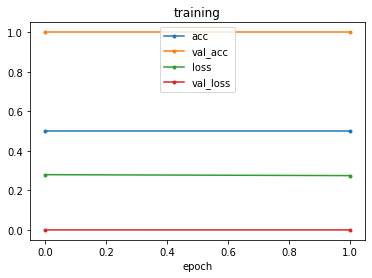

loss(mse):0.00038805254735052586
mae:0.018618891015648842
acc:1.0


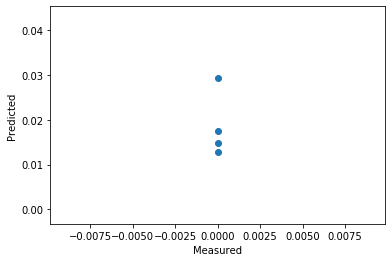

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_13 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 4s - loss: 0.5952 - mean_absolute_error: 0.6991 - acc: 0.0000e+00 - val_loss: 0.6002 - val_mean_absolute_error: 0.7195 - val_acc: 0.0000e+00
Epoch 2/2
 - 1s - loss: 0.5872 - mean_absolute_error: 0.6934 - acc: 0.0000e+00 - val_loss: 0.5934 - val_mean_absolute_error: 0.7147 - val_acc: 0.0000e+00


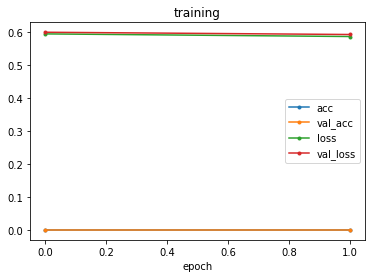

loss(mse):0.6100916862487793
mae:0.720669150352478
acc:0.0


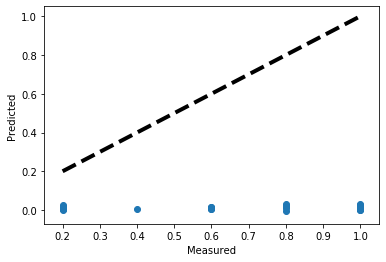

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 4s - loss: 0.0013 - mean_absolute_error: 0.0170 - acc: 0.8636 - val_loss: 0.0603 - val_mean_absolute_error: 0.0980 - val_acc: 0.6957
Epoch 2/2
 - 1s - loss: 0.0012 - mean_absolute_error: 0.0155 - acc: 0.8636 - val_loss: 0.0595 - val_mean_absolute_error: 0.0996 - val_acc: 0.6957


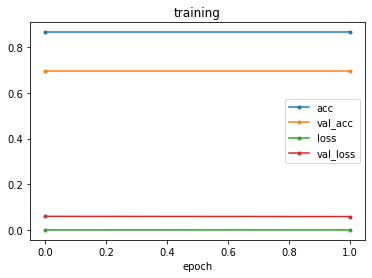

loss(mse):0.0012826599413529038
mae:0.017954537644982338
acc:0.9090909361839294


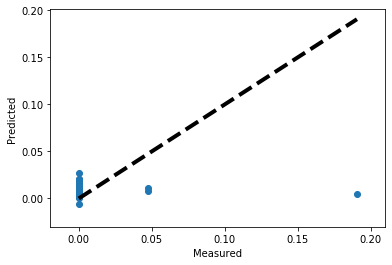

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_15 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 4s - loss: 0.0133 - mean_absolute_error: 0.0568 - acc: 0.5000 - val_loss: 0.0582 - val_mean_absolute_error: 0.1136 - val_acc: 0.4348
Epoch 2/2
 - 1s - loss: 0.0122 - mean_absolute_error: 0.0496 - acc: 0.5000 - val_loss: 0.0563 - val_mean_absolute_error: 0.1090 - val_acc: 0.4348


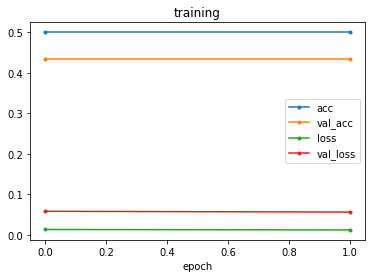

loss(mse):0.005525331012904644
mae:0.04255557805299759
acc:0.5151515007019043


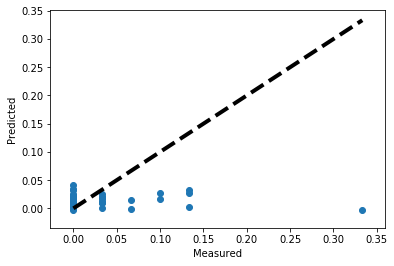

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 4s - loss: 2.5908e-04 - mean_absolute_error: 0.0099 - acc: 0.9091 - val_loss: 0.0536 - val_mean_absolute_error: 0.0874 - val_acc: 0.6087
Epoch 2/2
 - 1s - loss: 2.2079e-04 - mean_absolute_error: 0.0094 - acc: 0.9091 - val_loss: 0.0531 - val_mean_absolute_error: 0.0871 - val_acc: 0.6087


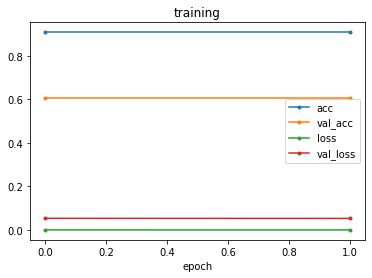

loss(mse):0.0010116422781720757
mae:0.019277747720479965
acc:0.6666666865348816


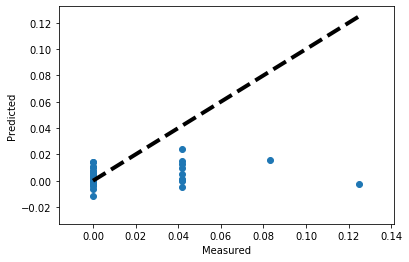

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_17 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 4s - loss: 0.6679 - mean_absolute_error: 0.7492 - acc: 0.0000e+00 - val_loss: 0.8244 - val_mean_absolute_error: 0.9035 - val_acc: 0.0000e+00


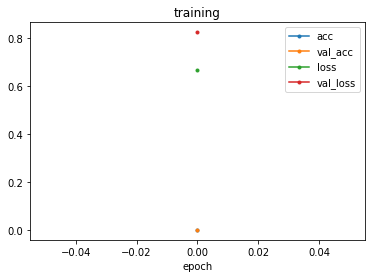

loss(mse):0.7123532295227051
mae:0.8397380709648132
acc:0.0


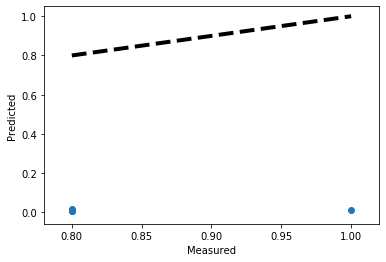

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 4s - loss: 0.2554 - mean_absolute_error: 0.2556 - acc: 0.7500 - val_loss: 3.4311e-05 - val_mean_absolute_error: 0.0058 - val_acc: 1.0000


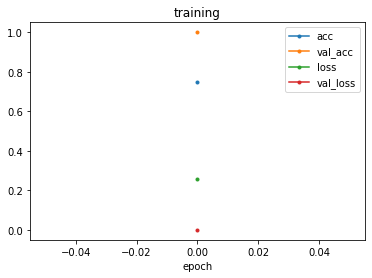

loss(mse):0.24392659962177277
mae:0.2505412697792053
acc:0.75


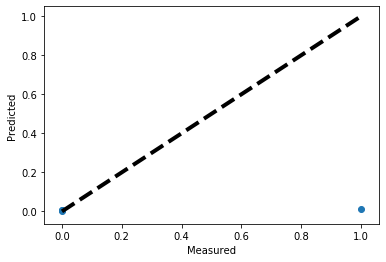

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_19 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 4s - loss: 0.3189 - mean_absolute_error: 0.3826 - acc: 0.5000 - val_loss: 0.0310 - val_mean_absolute_error: 0.1276 - val_acc: 0.5000


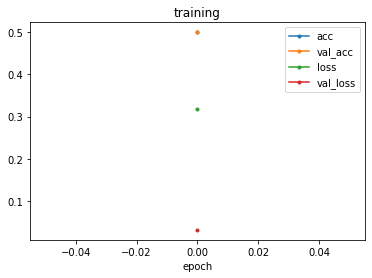

loss(mse):0.06748801469802856
mae:0.13630817830562592
acc:0.75


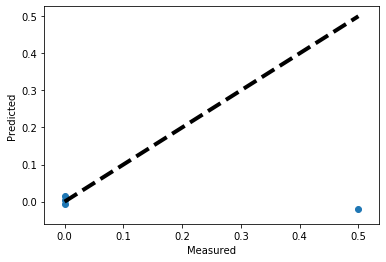

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/1
 - 4s - loss: 0.2806 - mean_absolute_error: 0.3368 - acc: 0.5000 - val_loss: 9.5825e-06 - val_mean_absolute_error: 0.0031 - val_acc: 1.0000


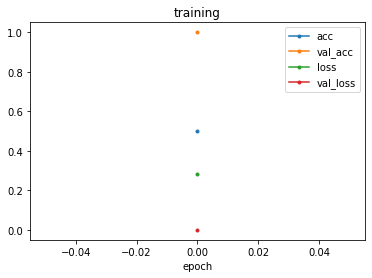

loss(mse):3.270251181675121e-05
mae:0.004878938663750887
acc:1.0


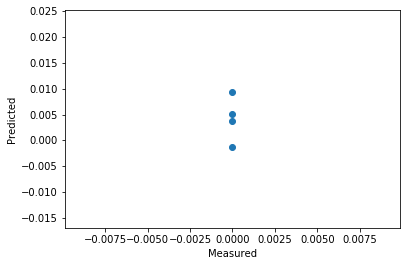

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_21 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 5s - loss: 0.5966 - mean_absolute_error: 0.7005 - acc: 0.0000e+00 - val_loss: 0.5971 - val_mean_absolute_error: 0.7171 - val_acc: 0.0000e+00


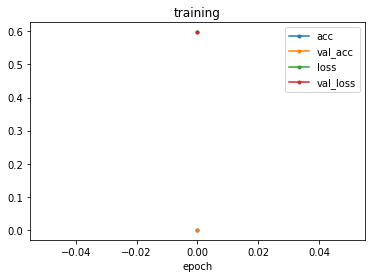

loss(mse):0.6223136782646179
mae:0.7280195951461792
acc:0.0


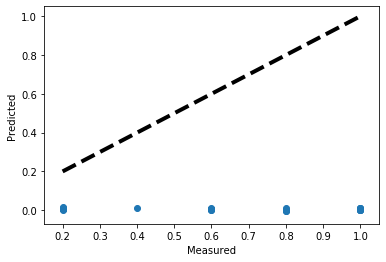

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_22 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 5s - loss: 0.0012 - mean_absolute_error: 0.0187 - acc: 0.8636 - val_loss: 0.0605 - val_mean_absolute_error: 0.1018 - val_acc: 0.6957


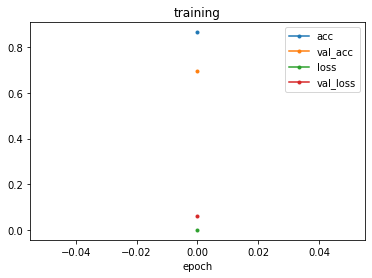

loss(mse):0.0011975291417911649
mae:0.014594812877476215
acc:0.9090909361839294


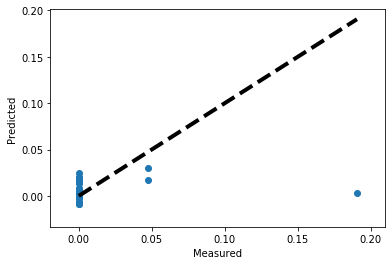

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_23 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 6s - loss: 0.0131 - mean_absolute_error: 0.0535 - acc: 0.5000 - val_loss: 0.0589 - val_mean_absolute_error: 0.1115 - val_acc: 0.4348


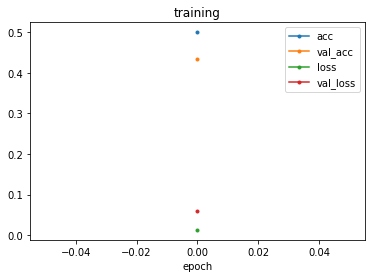

loss(mse):0.005770370364189148
mae:0.04011835902929306
acc:0.5151515007019043


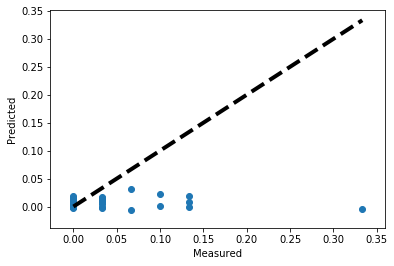

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_24 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/1
 - 6s - loss: 2.4770e-04 - mean_absolute_error: 0.0107 - acc: 0.9091 - val_loss: 0.0525 - val_mean_absolute_error: 0.0856 - val_acc: 0.6087


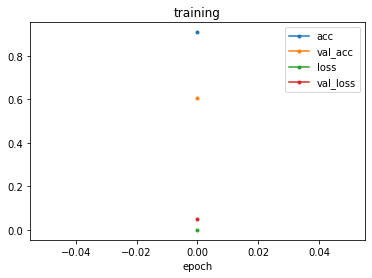

loss(mse):0.0010530275758355856
mae:0.020910579711198807
acc:0.6666666865348816


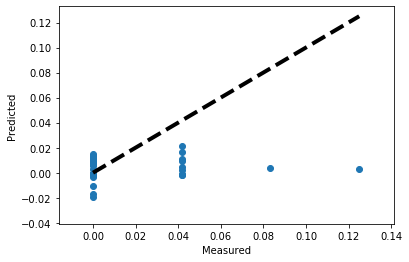

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_25 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 5s - loss: 0.6873 - mean_absolute_error: 0.7598 - acc: 0.0000e+00 - val_loss: 0.8230 - val_mean_absolute_error: 0.9014 - val_acc: 0.0000e+00
Epoch 2/2
 - 0s - loss: 0.6782 - mean_absolute_error: 0.7538 - acc: 0.0000e+00 - val_loss: 0.8160 - val_mean_absolute_error: 0.8975 - val_acc: 0.0000e+00


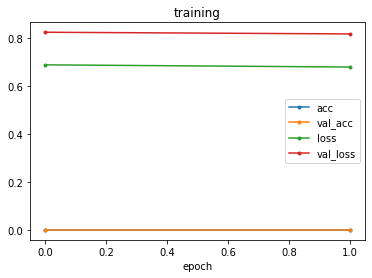

loss(mse):0.7036392688751221
mae:0.8349586725234985
acc:0.0


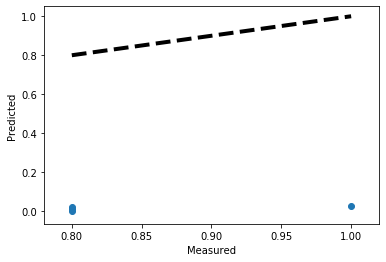

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_26 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 5s - loss: 0.2536 - mean_absolute_error: 0.2583 - acc: 0.7500 - val_loss: 1.5439e-04 - val_mean_absolute_error: 0.0092 - val_acc: 1.0000
Epoch 2/2
 - 0s - loss: 0.2502 - mean_absolute_error: 0.2564 - acc: 0.7500 - val_loss: 9.6675e-05 - val_mean_absolute_error: 0.0091 - val_acc: 1.0000


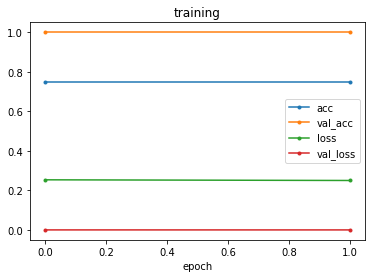

loss(mse):0.2504516541957855
mae:0.2603982090950012
acc:0.75


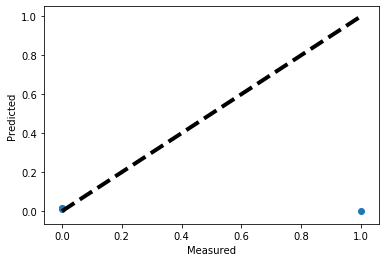

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_27 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 5s - loss: 0.3151 - mean_absolute_error: 0.3833 - acc: 0.5000 - val_loss: 0.0313 - val_mean_absolute_error: 0.1295 - val_acc: 0.5000
Epoch 2/2
 - 0s - loss: 0.3096 - mean_absolute_error: 0.3813 - acc: 0.5000 - val_loss: 0.0301 - val_mean_absolute_error: 0.1296 - val_acc: 0.5000


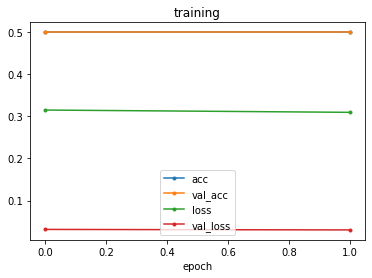

loss(mse):0.058464325964450836
mae:0.13188429176807404
acc:0.75


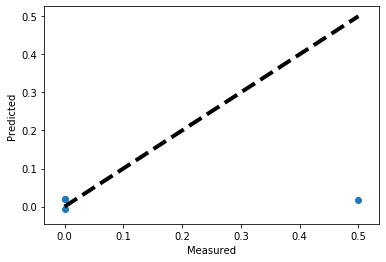

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 231, 8)            3512      
_________________________________________________________________
lstm_28 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 4 samples, validate on 2 samples
Epoch 1/2
 - 5s - loss: 0.2763 - mean_absolute_error: 0.3366 - acc: 0.5000 - val_loss: 6.2192e-05 - val_mean_absolute_error: 0.0064 - val_acc: 1.0000
Epoch 2/2
 - 0s - loss: 0.2725 - mean_absolute_error: 0.3332 - acc: 0.5000 - val_loss: 1.3424e-04 - val_mean_absolute_error: 0.0106 - val_acc: 1.0000


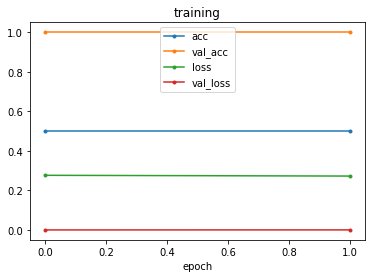

loss(mse):3.85494640795514e-05
mae:0.006108177825808525
acc:1.0


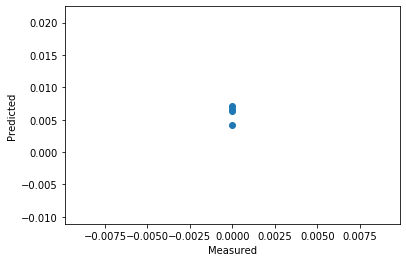

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_29 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 7s - loss: 0.5980 - mean_absolute_error: 0.7018 - acc: 0.0000e+00 - val_loss: 0.5949 - val_mean_absolute_error: 0.7166 - val_acc: 0.0000e+00
Epoch 2/2
 - 1s - loss: 0.5881 - mean_absolute_error: 0.6947 - acc: 0.0000e+00 - val_loss: 0.5866 - val_mean_absolute_error: 0.7108 - val_acc: 0.0000e+00


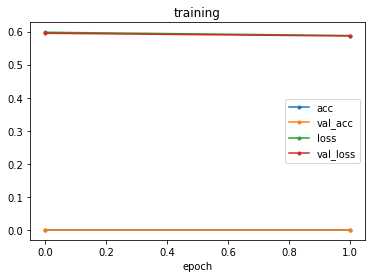

loss(mse):0.6134359836578369
mae:0.7223955392837524
acc:0.0


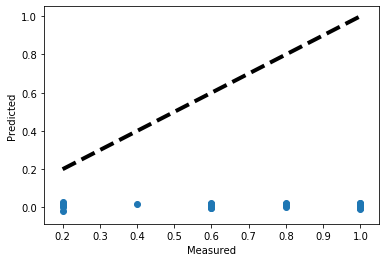

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_30 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 7s - loss: 0.0013 - mean_absolute_error: 0.0157 - acc: 0.8636 - val_loss: 0.0612 - val_mean_absolute_error: 0.0974 - val_acc: 0.6957
Epoch 2/2
 - 1s - loss: 0.0011 - mean_absolute_error: 0.0144 - acc: 0.8636 - val_loss: 0.0606 - val_mean_absolute_error: 0.0974 - val_acc: 0.6957


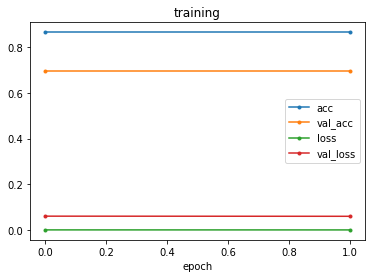

loss(mse):0.0012087280629202724
mae:0.015542801469564438
acc:0.9090909361839294


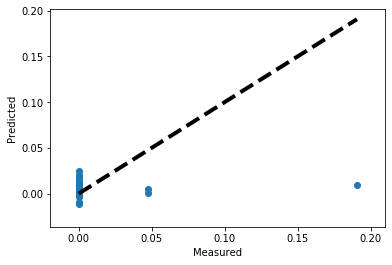

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_31 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2
 - 7s - loss: 0.0131 - mean_absolute_error: 0.0539 - acc: 0.5000 - val_loss: 0.0573 - val_mean_absolute_error: 0.1095 - val_acc: 0.4348
Epoch 2/2
 - 1s - loss: 0.0124 - mean_absolute_error: 0.0511 - acc: 0.5000 - val_loss: 0.0561 - val_mean_absolute_error: 0.1084 - val_acc: 0.4348


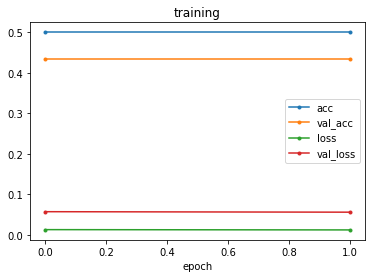

loss(mse):0.005537859629839659
mae:0.04102139547467232
acc:0.5151515007019043


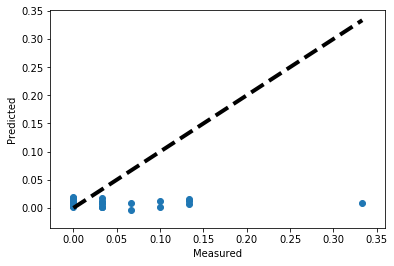

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 790, 8)            19880     
_________________________________________________________________
lstm_32 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 9         
Total params: 20,433
Trainable params: 20,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 44 samples, validate on 23 samples
Epoch 1/2


In [ ]:
grid_search()